In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cases = ['ASD',
        'SZ',
        'BIP',
        'DEL22q11_2',
        'DUP22q11_2',
        'DEL16p11_2',
        'DUP16p11_2',
        'DEL1q21_1',
        'DUP1q21_1']

cases = ['DUP1q21_1',
        'DEL1q21_1',
        'DUP22q11_2',
        'DUP16p11_2',
        'DEL16p11_2',
        'DEL22q11_2',
        'ASD',
        'SZ',
        'BIP',]

labels = ['DUP 1q21.1',
        'DEL 1q21.1',
        'DUP 22q11.2',
        'DUP 16p11.2',
        'DEL 16p11.2',
        'DEL 22q11.2',
        'ASD',
        'SZ',
        'BIP',]

p_intra = './results_paper/conditions/'

# Load Data

In [3]:
# Single Task
st_data_conn = []
for case in cases:
    folds_conn = []
    for fold in range(5):
        # Connectomes
        p_parent = os.path.join(p_intra, f"{case}/fold_{fold}")
        file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
        folds_conn.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1])[case])

    st_data_conn.append(folds_conn)

st_data_conn = dict(zip(cases,st_data_conn))

In [4]:
# Multi-task
mtl_data_conn = []
for fold in range(5):
    # Connectomes
    p_parent = os.path.join(p_intra, f"all/fold_{fold}")
    file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
    mtl_data_conn.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1]))


# Get Accuracy

In [5]:
# Single Task
st_acc_conn = []
st_acc_conn_std = []
for case in cases:
    # Connectomes
    vals = [st_data_conn[case][fold]['Accuracy/test'].iloc[-1] for fold in range(5)]
    st_acc_conn.append(np.mean(vals))
    st_acc_conn_std.append(np.std(vals))


st_acc_conn = pd.Series(st_acc_conn,index=cases)
st_acc_conn_std = pd.Series(st_acc_conn_std,index=cases)

In [6]:
# Multi-task
mtl_acc_conn = []
for fold in range(5):
    # Connectomes
    df = mtl_data_conn[fold].transpose().reset_index()
    df = df[df['level_1']=='Accuracy/test'].set_index('level_0')[99]
    mtl_acc_conn.append(df)
    
mtl_acc_conn_std = pd.concat(mtl_acc_conn,axis=1).std(axis=1)
mtl_acc_conn = pd.concat(mtl_acc_conn,axis=1).mean(axis=1)

# Tables

In [7]:
# Connectomes
df_conn = pd.concat([st_acc_conn,mtl_acc_conn,st_acc_conn_std,mtl_acc_conn_std],axis=1)
df_conn.columns = ['ST','MTL','ST_std','MTL_std']
df_conn

,ST,MTL,ST_std,MTL_std
DUP1q21_1,53.214286,57.857143,22.314999,16.874764
DEL1q21_1,70.000000,70.000000,14.142136,15.811388
DUP22q11_2,41.388889,54.722222,13.391079,6.484788
DUP16p11_2,64.285714,62.857143,4.517540,9.313146
DEL16p11_2,73.461538,64.230769,7.730674,20.514824
DEL22q11_2,84.967320,74.509804,8.571815,7.336583
ASD,61.085219,60.872453,2.463449,2.468733
SZ,75.709892,73.983760,1.652202,3.123811
BIP,79.012097,82.177419,3.023118,3.540732


In [8]:
df_conn.mean()

ST         67.013884
MTL        66.801190
ST_std      8.645223
MTL_std     9.496530
dtype: float64

# Plots

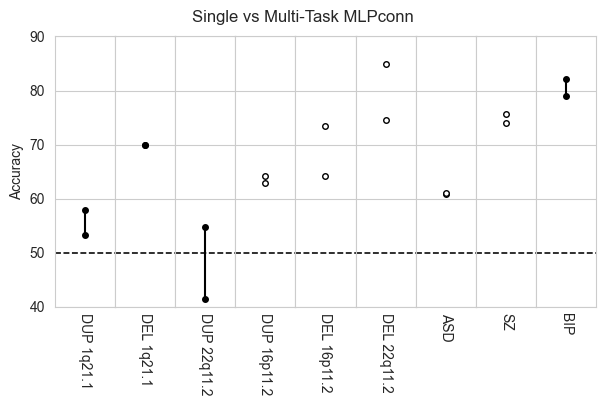

In [10]:
###############
# CONNECTOMES #
###############
title = 'Single vs Multi-Task MLPconn'
fig,ax = plt.subplots(1,len(cases),figsize=(6,4),sharey=True,sharex=True)
plt.yticks([40,50,60,70,80,90])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,case in enumerate(cases):
    st_acc = df_conn.loc[case]['ST']
    mtl_acc = df_conn.loc[case]['MTL']
    if st_acc > mtl_acc:
        mfc = 'white'
        ls =''
    else:
        mfc = colors[0]
        ls = '-'

    ax[j].plot(5,mtl_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot(5,st_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot((5,5),(st_acc,mtl_acc),color=colors[0],ls=ls)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(labels[j],rotation=270)

    lines = ax[j].get_ygridlines()
    b = lines[1]
    b.set_color('black')
    b.set_linewidth(1.15)
    b.set_linestyle('--')

ax[0].set_ylabel('Accuracy')
plt.suptitle(title)
plt.ylim(40,90)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join(p_intra,'figures/st_vs_mtl.png'),dpi=300)